In [1]:
import numpy as np
import nibabel as nib
import glob
from lito_radiomics.lito_radiomics.lito_features import shape2D
import cupy as cp
from cupyx.scipy import ndimage
from cupy.linalg import eigh, svd
import cvxpy as cvxp
import math
import pickle as pkl
from radiomics import featureextractor
import pandas as pd
from itertools import cycle
import datatable as dt
from math import isclose
import dask
from dask import delayed, compute
from concurrent.futures import ThreadPoolExecutor
import SimpleITK as sitk
import matplotlib.colors as mcolors
from scipy import spatial
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from skimage.measure import EllipseModel, find_contours
from skimage.draw import ellipse
from nibabel.affines import apply_affine
import random
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
cases_thresh = {
    'thresh_1' : 0.1, 
    'thresh_2' : 0.1,
    'thresh_4' : 0.1,
    'thresh_5' : 0.2,
    'thresh_6' : 0.2,
    'thresh_7' : 0.1,
    'thresh_8' : 0.1,
    'thresh_9' : 0.1,
    'thresh_10' : 0.1,
    'thresh_12' : 0.1,
    'thresh_13' : 0.2,
    'thresh_14' : 0.3,
    'thresh_15': 0.1,
    'thresh_16': 0.1,
    'thresh_17': 0.22,
    'thresh_18': 0.1,
    'thresh_19': 0.1,
    'thresh_20': 0.1,
    'thresh_21': 0.2,
    'thresh_22': 0.2,
    'thresh_23': 0.2,
    'thresh_24': 0.2,
    'thresh_25': 0.2,
    'thresh_26': 0.2,
    'thresh_27': 0.1,
    'thresh_28': 0.2,
    'thresh_29': 0.1,
    'thresh_30': 0.1,
    'thresh_31': 0.1,
    'thresh_32': 0.1,
    'thresh_33': 0.1,
    'thresh_34': 0.2,
    'thresh_35': 0.2,
    'thresh_36': 0.2,
    'thresh_37': 0.2,
    'thresh_38': 0.2,
    'thresh_39': 0.15,                       
    'thresh_40': 0.1,
    'thresh_41': 0.2,
    'thresh_42': 0.3,
    'thresh_43': 0.2,
    'thresh_44': 0.2,
    'thresh_45': 0.2,
    'thresh_46': 0.2,
    'thresh_47': 0.2,
    'thresh_48': 0.2,
    'thresh_49': 0.25,
    'thresh_50': 0.2,
    'thresh_51': 0.15,
    'thresh_52': 0.2,
    'thresh_53': 0.2,
    'thresh_54': 0.2,
    'thresh_55': 0.2,
    'thresh_56': 0.2,
    'thresh_57': 0.2,
    'thresh_58': 0.2,
    'thresh_59': 0.2,
    'thresh_60': 0.2,
    'thresh_61': 0.2,
    'thresh_62': 0.2,
    'thresh_63': 0.2,
    'thresh_64': 0.2,
    'thresh_65': 0.2,
    'thresh_66': 0.2,
    'thresh_67': 0.2,
    'thresh_68': 0.2,
    'thresh_69': 0.2,
    'thresh_70': 0.15,
    'thresh_04': 0.1,
    'thresh_05': 0.2,
    'thresh_06': 0.2,
    'thresh_07': 0.1,
    'thresh_08': 0.1,
    'thresh_09': 0.1,
    'thresh_10': 0.1,
    'thresh_12': 0.1,
    'thresh_13': 0.2,
    'thresh_14': 0.3,
    'thresh_15': 0.1,
    'thresh_16': 0.1,
    'thresh_17': 0.22,
    'thresh_18': 0.1,
    'thresh_19': 0.1,
    'thresh_20': 0.1,
    'thresh_21': 0.2,
    'thresh_22': 0.2,
    'thresh_23': 0.2,
    'thresh_24': 0.2,
    'thresh_25': 0.2,
    'thresh_26': 0.2,
    'thresh_27': 0.1,
    'thresh_28': 0.2,
    'thresh_29': 0.1,
    'thresh_30': 0.1,
    'thresh_31': 0.1,
    'thresh_32': 0.1,
    'thresh_33': 0.1,
    'thresh_34': 0.2,
    'thresh_35': 0.2,
    'thresh_36': 0.2,
    'thresh_37': 0.2,
    'thresh_38': 0.2,
    'thresh_39': 0.15, 
    'thresh_71': 0.2,
    'thresh_72': 0.1,
    'thresh_73': 0.2,
    'thresh_74' : 0.2,
    'thresh_75' : 0.15,
    'thresh_76' : 0.15,
    'thresh_77' : 0.2,
    'thresh_78' : 0.2,
    'thresh_79' : 0.2,
    'thresh_80' : 0.4,
    'thresh_81' : 0.1,
    'thresh_82' : 0.1,
    'thresh_83' : 0.1,
    'thresh_84' : 0.2,
    'thresh_85' : 0.2,
    'thresh_86' : 0.2,
    'thresh_87' : 0.2,
    'thresh_88' : 0.4,
    'thresh_89' : 0.2,
    'thresh_90' : 0.2,
    'thresh_91' : 0.2,
    'thresh_92' : 0.2,
    'thresh_93' : 0.2,
    'thresh_94' : 0.15,
    'thresh_95' : 0.25,
    'thresh_96' : 0.2,
    'thresh_97' : 0.2,
    'thresh_98' : 0.2,
    'thresh_99' : 0.25,
    'thresh_100' : 0.2,
    'thresh_101' : 0.2,
    'thresh_102' : 0.2,
    'thresh_103' : 0.2,
    'thresh_104' : 0.2,
    'thresh_105' : 0.2}

In [3]:
def check_registration(im1, im2):
    ax, az=im1.header['qoffset_x'], im1.header['qoffset_z'] 
    bx, bz=im2.header['qoffset_x'], im2.header['qoffset_z']

    if math.isclose(az, bz, rel_tol=0.05) and math.isclose(ax, bx, rel_tol=0.05):
        return True
    else:
        return False
    
def rescale_to_255(array):
    """
    Rescale the values of a 2D NumPy array to the range [0, 255].
    
    Parameters:
        array (numpy.ndarray): Input 2D array.
        
    Returns:
        numpy.ndarray: Rescaled array with values in the range [0, 255].
    """
    min_val = np.min(array)
    max_val = np.max(array)

    # Ensure the array is not constant to avoid division by zero
    if min_val != max_val:
        scaled_array = 255 * (array - min_val) / (max_val - min_val)
    else:
        scaled_array = array

    return scaled_array.astype(np.uint8)

def fill_holes(mask):
    filled_mask = scipy.ndimage.binary_fill_holes(mask[0, :, :]).astype(float)
    return filled_mask

def ellipse_perimeter(a, b):
    """
    Compute the perimeter of an ellipse using Ramanujan's approximation formula.
    
    Parameters:
        a (float): Length of the semi-major axis.
        b (float): Length of the semi-minor axis.
    
    Returns:
        float: Perimeter of the ellipse.
    """
    h = ((a - b) / (a + b))**2
    perimeter = np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))
    return perimeter
    

In [4]:
def compute_metrics_ellipse(a, b, eigen_vect, mask_slice, center=None):
    
    angle1 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0])
    angle2 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0]) + np.deg2rad(90)
    
    if center is None:
        center = ndimage.center_of_mass(cp.asarray(sitk.GetArrayFromImage(mask_slice)))
        
    xy1 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle1))
    xy2 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle2))
    
    ell1 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle1)
    ell2 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle2)

    contours = find_contours(sitk.GetArrayFromImage(mask_slice), 0.5)
    contours = [np.flip(contours[k]) for k in range(len(contours))]

    ellipse_estimation = EllipseModel()
    try:
        if ellipse_estimation.estimate(xy1):
            residuals1 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
            
        if ellipse_estimation.estimate(xy2):
            residuals2 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
    except TypeError:
        residuals1, residuals2 = None, None
        
    shape_slice = sitk.GetArrayFromImage(mask_slice).shape
    mask_ellipse1 = np.zeros(shape_slice)
    mask_ellipse1[[i for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    mask_ellipse2 = np.zeros(shape_slice)
    mask_ellipse2[[i for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    dice1=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse1.ravel())
    dice2=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse2.ravel())

    try:
        if dice1 >= dice2:
            return residuals1, dice1, xy1, mask_ellipse1, center
        else:
            return residuals2, dice2, xy2, mask_ellipse2, center
    except UnboundLocalError:
        return False, False, False, False, False
    
    
def standardize_roi(image, mask, desired_area):

    # Calculate the current area of the ROI
    current_area = cp.sum(mask)

    # Calculate the scaling factor
    scale_factor = cp.sqrt(desired_area / current_area)
    
    return ndimage.zoom(cp.array(image), scale_factor), ndimage.zoom(cp.array(mask), scale_factor, order=0)


def _extracted_from_features_extraction2D_4(arg0, cut, data_spacing):
    result = sitk.GetImageFromArray(arg0[int(cut), :, :])
    result.SetSpacing(
        (
            float(data_spacing[0]),
            float(data_spacing[1]),
            float(data_spacing[2]),
        )
    )
    result = sitk.JoinSeries(result)

    return result

def _extracted_from_features_extraction2D_11():
    result = featureextractor.RadiomicsFeatureExtractor(force2D=True)
    result.disableAllFeatures()
    result.enableFeaturesByName(
        shape2D=[
            "PerimeterSurfaceRatio",
            "Sphericity",
            "MajorAxisLength",
            "MinorAxisLength",
            "Perimeter",
        ]
    )

    return result


def features_extraction2D(a_im, a_ma, cut, filled=True):

    data_spacing = [1,1,1]
    sitk_img = _extracted_from_features_extraction2D_4(a_im, cut, data_spacing)
    sitk_mask = _extracted_from_features_extraction2D_4(a_ma, cut, data_spacing)
    sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

    if filled is True:
        sitk_mask = sitk.GetImageFromArray(fill_holes(sitk.GetArrayFromImage(sitk_mask)))
    resized_image, resized_mask = standardize_roi(sitk.GetArrayFromImage(sitk_img), sitk.GetArrayFromImage(sitk_mask), 1250)
    resized_image = sitk.GetImageFromArray(cp.asnumpy(resized_image))
    resized_mask = sitk.GetImageFromArray(cp.asnumpy(resized_mask))
    features_40_slice = _extracted_from_features_extraction2D_11()
    features_40_slice_resized = _extracted_from_features_extraction2D_11()
    
    return sitk_img, sitk_mask, resized_image, resized_mask, features_40_slice, features_40_slice_resized


def check_orientation(ct_image, ct_arr):
    """
    Check the NIfTI orientation, and flip to  'RPS' if needed.
    :param ct_image: NIfTI file
    :param ct_arr: array file
    :return: array after flipping
    """
    x, y, z = nib.aff2axcodes(ct_image.affine)
    
    if x != 'R':
        ct_arr = np.rot90(ct_arr, axes=(0,2), k=1)
    if y != 'P':
        ct_arr = np.flip(ct_arr, axis=1)
    if z != 'S':
        ct_arr = np.flip(ct_arr, axis=2)
    
    return ct_arr


def remove_out_of_box_mask(mask, box):
    _, y, z = np.where(~box.mask)
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max()
    
    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)


    mask[:, :y_min_iso, :] = mask[:, y_max_iso+1:, :] = mask[:, :, :z_min_iso] = mask[:, :, z_max_iso+1:] = 0
    
    return mask


def resegment_thresholding(image, mask, thresh=0.2):
    
    max = (image*mask).max()
    new_mask20= np.ma.masked_where((image*mask) > thresh*max, mask)

    return new_mask20.mask.astype(float)


def random_slice_selection(rotated_mask):
    
    min_mask = np.argwhere(rotated_mask==1)[:, 0].min()
    max_mask = np.argwhere(rotated_mask==1)[:, 0].max()
    x = random.randint(min_mask, max_mask+1)
    print(x)

    return x


def apply_thresh(a_im, a_ma, a_ma_bb, thresh):
    
    a_ma_threshed = resegment_thresholding(np.array(a_im.dataobj), np.array(a_ma.dataobj), thresh=thresh)
    original_new_mask = nib.Nifti1Image(ndimage.binary_fill_holes(cp.array(a_ma_threshed)).astype(np.uint8), affine=a_ma.affine)

    final_image = cp.float32(a_im.dataobj)
    final_mask = cp.float32(original_new_mask.dataobj.get())
    final_mask_bb = cp.float32(a_ma_bb)
    final_mask = remove_out_of_box_mask(final_mask, np.ma.masked_equal(final_mask_bb, 0))

    return final_image, final_mask, final_mask_bb


def plot_1slice(im, ma, bb, center_ell, slice_nb, ell, dice, dice_resized):
    
    plt.close('all')
    inside_bb = bb * im
    to_display = np.ma.masked_equal(inside_bb, 0)

    x, y, z = np.where(~to_display.mask)

    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max() 

    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)

    y_mask, x_mask = np.where(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]==1)
    x_min_mask = x_mask.min()
    x_max_mask = x_mask.max()
    y_min_mask = y_mask.min()
    y_max_mask = y_mask.max()
    
    center = ndimage.center_of_mass(cp.asarray(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]))
    translated_ell = ell - (np.array([center_ell[1].item(), center_ell[0].item()]) - np.array([center[1].item(), center[0].item()]))
    center_ma = [x_min_mask + (x_max_mask-x_min_mask)/2, y_min_mask + (y_max_mask-y_min_mask)/2]
    plt.imshow(im[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], interpolation='none', cmap='grey')
    plt.imshow(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], alpha=0.25*(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]>0))
    plt.plot(translated_ell[:, 0], translated_ell[:, 1])
    #plt.scatter(center[1].get(), center[0].get())
    #plt.scatter(center_ma[0], center_ma[1])
    plt.title(f'{str(dice)[:5]}')# {str(dice_resized)[:5]}')

    plt.show()
    
    
def plot_slices(slices_im, slices_ma, slices_bb, center_ells, ells, dices, n, mins, maxs):

    n_columns = 8
    n_rows = n // n_columns

    if n % n_columns != 0:
        n_rows += 1
    plt.close('all')
    _, axs = plt.subplots(n_rows, n_columns, sharex=True, sharey=True, figsize=(10, 5))
    axs = axs.flatten()
    for i in range(n):
        inside_bb = slices_bb[i] * slices_im[i]
        to_display = np.ma.masked_equal(inside_bb, 0)

        y, z = np.where(~to_display.mask)
        y_min = y.min()
        y_max = y.max()
        z_min = z.min()
        z_max = z.max() 

        y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
        y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
        z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
        z_max_iso = int(z_max - (z_max-z_min)/2 + 25)
        
        y_mask, x_mask = np.where(slices_ma[i][y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]==1)
        x_min_mask = x_mask.min()
        x_max_mask = x_mask.max()
        y_min_mask = y_mask.min()
        y_max_mask = y_mask.max()
        
        #center_ma = [x_min_mask + (x_max_mask-x_min_mask)/2, y_min_mask + (y_max_mask-y_min_mask)/2]
        center = ndimage.center_of_mass(cp.asarray(slices_ma[i][y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]))
        translated_ell = ells[i] - (np.array([center_ells[i][1].item(), center_ells[i][0].item()]) - np.array([center[1].item(), center[0].item()]))
        
        axs[i].imshow(slices_im[i][y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], interpolation='none', cmap='grey')#, vmin=0, vmax=255)#mins[i], vmax=maxs[i])
        axs[i].imshow(slices_ma[i][y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], alpha=0.25*(slices_ma[i][y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]>0))
        axs[i].plot(translated_ell[:, 0], translated_ell[:, 1])
        axs[i].scatter(center[1].get(), center[0].get())
        #axs[i].scatter(center_ma[0], center_ma[1])
        axs[i].title.set_text(f'{str(dices[i])[:5]}') # {str(dices_resized[i])[:5]}')

    for ax in axs:
        if not bool(ax.get_images()):
            ax.remove()
    
    _.tight_layout()
    plt.show()


def RPCA(mask_orig, lbda, lbda_search=True):
    # Define a function to perform RPCA
    def compute_rpca(X, lambda_param, std, mean, mask):
        # Define variables
        L = cvxp.Variable(X.shape)  # Low-rank component
        S = cvxp.Variable(X.shape)  # Sparse component

        # Define objective
        objective = cvxp.Minimize(cvxp.norm(L, 'nuc') + lambda_param * cvxp.norm(S, 1))

        # Constraints
        constraints = [X == L + S]

        # Solve RPCA
        problem = cvxp.Problem(objective, constraints)
        problem.solve()  # You can change the solver if needed
        
        # Check if the optimization problem was solved successfully
        if problem.status not in ["optimal", "optimal_inaccurate"]:
            raise ValueError(f"Optimization problem not solved successfully. Status: {problem.status}")

        # Step 4: Extract the low-rank component
        low_rank_coords = cp.array(L.value)
        
        # Step 5: Enforce rank-2 on the low-rank component
        U, S, VT = svd(low_rank_coords, full_matrices=False)
        low_rank_coords_rank2 = (U[:, :2] @ cp.diag(S[:2]) @ VT[:2, :])

        low_rank_coords_original = low_rank_coords_rank2 * cp.array(std) + cp.array(mean)
        
        center = np.mean(low_rank_coords_original, axis=0)
        
        # Step 6: Compute covariance and ellipse parameters
        cov_matrix = cp.cov(low_rank_coords_original, rowvar=False)
        eigenvalues, eigenvectors = eigh(cov_matrix)
        eigenvalues = np.maximum(np.array(eigenvalues.get()), 0)
        a = 2*np.sqrt(eigenvalues)[0]
        b = 2*np.sqrt(eigenvalues)[1]
        
        res, di, xy, mask_ellipse, center = compute_metrics_ellipse(a, b, np.array(eigenvectors.get()), mask, center=center)
       
        # Return results
        return {'residuals': res, 
                'dice': di, 
                'xy': xy,
                'mask_ellipse': mask_ellipse,
                'center': center,
                'lambda': lambda_param
                }
        
    # Example mask: Replace with your actual mask
    mask = sitk.GetArrayFromImage(mask_orig)

    # Step 1: Extract coordinates of non-zero pixels
    coords = np.column_stack(np.nonzero(mask))  # Shape: (n_points, 2)

    # Step 2: Standardize the coordinates
    mean_coords = np.mean(coords, axis=0)  # Mean for each axis
    std_coords = np.std(coords, axis=0)    # Standard deviation for each axis
    standardized_coords = (coords - mean_coords) / std_coords
    results = []
    
    if lbda_search:
        # Generate lambda values around the Frobenius-based lambda
        frobenius_norm = np.linalg.norm(standardized_coords, 'fro')
        alpha = 0.1
        lambda_center = alpha * (frobenius_norm / np.sqrt(standardized_coords.shape[0]))
        lambda_values = [lambda_center * factor for factor in np.linspace(0.2, 1.5, 15)]
        
        
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(compute_rpca, standardized_coords, lam, std_coords, mean_coords, mask_orig) for lam in lambda_values]
            for future in futures:
                results.append(future.result())
        # Find the dictionary with the largest 'di'
        results = [max(results, key=lambda d: d['dice'])]
    else:
        # RPCA objective
        if lbda is None:
            frobenius_norm = np.linalg.norm(standardized_coords, 'fro')
            lambda_param = 0.1 * (frobenius_norm / np.sqrt(standardized_coords.shape[0]))
            print("lambda:" + str(lambda_param))
            
        else:
            lambda_param = lbda
        results.append(compute_rpca(standardized_coords, lambda_param, std_coords, mean_coords, mask_orig))
        
    return results[0]


def compute_ellipse_envelope(mask):
    coords = np.column_stack(np.nonzero(sitk.GetArrayFromImage(mask)))
        
    # Fit an Elliptic Envelope
    envelope = EllipticEnvelope().fit(coords)
    center = envelope.location_
    # Access the covariance matrix of the ellipse
    covariance = cp.array(envelope.covariance_)
    eigenvalues, eigenvectors = eigh(covariance)
    
    return eigenvalues, eigenvectors, center


def for_ellipse_creation(mask, features_extractor=None, image=None, method='RPCA', lbda=None):
    if method == 'PCA':
        results = features_extractor.execute(image, mask)
        features_lito = shape2D.LitoRadiomicsShape2D(image, mask)
        features_eigenvect = features_lito.getEigenVectorsFeatureValue()
        
        a = float(results['original_shape2D_MajorAxisLength'])/2  # Semi-major axis
        b = float(results['original_shape2D_MinorAxisLength'])/2  # Semi-minor axis
        perimeter = ellipse_perimeter(a, b)
        real_perimeter = float(results['original_shape2D_Perimeter'])
        ellipticity = perimeter/real_perimeter
        return results, features_eigenvect, a, b, ellipticity
    
    elif method == 'MCD':
        eigenvalues_MCD, eigenvectors_MCD, center_MCD = compute_ellipse_envelope(mask)
        a = 2*np.sqrt(np.array(eigenvalues_MCD.get()))[0]
        b = 2*np.sqrt(np.array(eigenvalues_MCD.get()))[1]
        return eigenvectors_MCD, a, b, center_MCD
    
    elif method == 'RPCA':
        return RPCA(mask, lbda)

In [5]:
def compute_slices_dice(case):
    path_case = '/mnt/data/psteinmetz/neotex/to_process/Baseline_data/' + str(case)
    results_glob = {}
    
    results = {}
    print(path_case)

    if all([k not in case for k in ['105', '10', '14', '85', '39', '80', '57', '56']]) is True: 
        path_MRI = glob.glob(path_case + '/RawVolume/*substracted_resampled_Bspline_zscore_without_tumour.nii.gz')[0]
        
    else:
        path_MRI = glob.glob(path_case + '/RawVolume/*dyn1_bias_corrected_1_resampled_Bspline_zscore_without_tumour.nii.gz')[0]
        
    path_tumor = path_case + '/RoiVolume/C1_volume_resampled_NN.nii.gz'
    path_bb = path_case + '/RoiVolume/Bounding_box.nii.gz'
    
    image = nib.load(path_MRI)
    mask_bb = nib.load(path_bb)
    mask = nib.load(path_tumor)
    filled = True
    
    with cp.cuda.Device(1):
        a_im_rescaled = nib.Nifti1Image(rescale_to_255(check_orientation(image, np.array(image.dataobj))), affine=image.affine)
        a_im = nib.Nifti1Image(check_orientation(image, np.array(image.dataobj)), affine=image.affine)
        a_ma = check_orientation(mask, np.array(mask.dataobj))
        a_ma[a_ma > 0.1] = 1
        a_ma[a_ma <=0.1] = 0
        if a_ma.shape != np.array(a_im.dataobj).shape:
            nb_columns_to_delete = abs(np.array(a_ma.shape) - np.array(np.array(a_im.dataobj).shape))
            for axis, diff in enumerate(nb_columns_to_delete):
                if diff > 0:  # Only trim if `a_ma` is larger along this axis
                    # Calculate the number of elements to trim from each side
                    trim_start = diff // 2
                    trim_end = diff - trim_start
                    slicing = [slice(None)] * a_ma.ndim  # Create full slicing for all axes
                    slicing[axis] = slice(trim_start, a_ma.shape[axis] - trim_end)
                    a_ma = a_ma[tuple(slicing)]  # Apply slicing
        a_ma = nib.Nifti1Image(a_ma, affine=mask.affine)
        a_ma_bb = check_orientation(mask_bb, np.array(mask_bb.dataobj))
        thresh = cases_thresh['thresh_' + case.split('/')[-1]]
        
        final_image, final_mask, final_bb = apply_thresh(a_im, a_ma, a_ma_bb, thresh)
        biggest_cut_size = np.max([np.count_nonzero(final_mask[k, :, :]) for k in range(final_mask.shape[0])])
        slices_im, slices_ma, slices_bb, slices_results, slices_contours, slices_centers = [], [], [], [], [], []
        for k in range(final_mask.shape[0]):
            slice_ma_for_db = final_mask[k, :, :]
            size_slice = np.count_nonzero(slice_ma_for_db)
            if size_slice > 0.1*biggest_cut_size:
                print('Size biggest cut = ' + str(biggest_cut_size) + ' Size cut = ' + str(size_slice))
                sitk_img, sitk_mask, resized_image, resized_mask, features_40_slice, features_40_slice_resized = features_extraction2D(final_image, final_mask, k)
            
                image = sitk_img[:, :, 0] if filled is True else sitk_img
                resized_image = resized_image[:, :, 0] if filled is True else resized_image
                slices_im.append(final_image[k, :, :])
                slices_ma.append(slice_ma_for_db)
                slices_bb.append(final_bb[k, :, :])
                results, features_eigenvect, a, b, ellipticity = for_ellipse_creation(sitk_mask, features_40_slice, image, method='PCA')
                results_resized, features_eigenvect_resized, a_resized, b_resized, _ = for_ellipse_creation(resized_mask, features_40_slice_resized, resized_image, method='PCA')
                eigenvectors_MCD,  a_MCD, b_MCD, center_MCD = for_ellipse_creation(sitk_mask, method='MCD')

                res_MCD, di_MCD, cont_ellipse_MCD, mask_ell_MCD, center_MCD = compute_metrics_ellipse(a_MCD, b_MCD, np.array(eigenvectors_MCD.get()), sitk_mask, center=center_MCD)
                results_rpca = for_ellipse_creation(sitk_mask, method='RPCA')
                res_rpca, di_rpca, cont_ellipse_rpca, mask_ell_rpca, center_rpca = (results_rpca[key] for key in ['residuals', 'dice', 'xy', 'mask_ellipse', 'center'])

                res, di, cont_ellipse, mask_ell, center = compute_metrics_ellipse(a, b, features_eigenvect, sitk_mask)
                res_resized, di_resized, _, _, _ = compute_metrics_ellipse(a_resized, b_resized, features_eigenvect_resized, resized_mask)
                results= {
                    'Dice_PCA': di,
                    'Dice_MCD': di_MCD,
                    'Dice_RPCA': di_rpca,
                    'Dice_PCA_resized': di_resized,
                    'Residuals_PCA': res,
                    'Residuals_MCD': res_MCD,
                    'Residuals_RPCA': res_rpca,
                    'Residuals_PCA_resized': res_resized
                }
                contours = {
                    'PCA': cont_ellipse,
                    'RPCA': cont_ellipse_rpca,
                    'MCD': cont_ellipse_MCD
                }
                centers = {
                    'PCA': center,
                    'RPCA': center_rpca,
                    'MCD': center_MCD
                }
                slices_results.append(results)
                slices_contours.append(contours)
                slices_centers.append(centers)
                print('PCA, {}, MCD {}, RPCA {}'.format(di, di_MCD, di_rpca))
                
    return slices_im, slices_ma, slices_bb, slices_results, slices_contours, slices_centers

In [6]:
#slices_im, slices_ma, slices_bb, slices_results, slices_contours, slices_centers = compute_slices_dice('72')

In [7]:
def compute_slices_dice_dask(case, gpu_ids=[0, 1, 2]):
    path_case = f'/mnt/data/psteinmetz/neotex/to_process/Baseline_data/{case}'
    results_glob = {}

    print(path_case)

    # Determine MRI and tumor paths
    if all(k not in case for k in ['105', '10', '14', '85', '39', '80', '57', '56']):
        path_MRI = glob.glob(path_case + '/RawVolume/*substracted_resampled_Bspline_zscore_without_tumour.nii.gz')[0]
    else:
        path_MRI = glob.glob(path_case + '/RawVolume/*dyn1_bias_corrected_1_resampled_Bspline_zscore_without_tumour.nii.gz')[0]

    path_tumor = f'{path_case}/RoiVolume/C1_volume_resampled_NN.nii.gz'
    path_bb = f'{path_case}/RoiVolume/Bounding_box.nii.gz'

    # Load the images and masks
    image = nib.load(path_MRI)
    mask_bb = nib.load(path_bb)
    mask = nib.load(path_tumor)

    filled = True

    with cp.cuda.Device(gpu_ids[0]):
        a_im_rescaled = nib.Nifti1Image(rescale_to_255(check_orientation(image, np.array(image.dataobj))), affine=image.affine)
        a_im = nib.Nifti1Image(check_orientation(image, np.array(image.dataobj)), affine=image.affine)
        a_ma = check_orientation(mask, np.array(mask.dataobj))
        a_ma[a_ma > 0.1] = 1
        a_ma[a_ma <= 0.1] = 0

        if a_ma.shape != np.array(a_im.dataobj).shape:
            nb_columns_to_delete = abs(np.array(a_ma.shape) - np.array(np.array(a_im.dataobj).shape))
            for axis, diff in enumerate(nb_columns_to_delete):
                if diff > 0:  # Only trim if `a_ma` is larger along this axis
                    # Calculate the number of elements to trim from each side
                    trim_start = diff // 2
                    trim_end = diff - trim_start
                    slicing = [slice(None)] * a_ma.ndim  # Create full slicing for all axes
                    slicing[axis] = slice(trim_start, a_ma.shape[axis] - trim_end)
                    a_ma = a_ma[tuple(slicing)]  # Apply slicing

        a_ma = nib.Nifti1Image(a_ma, affine=mask.affine)
        a_ma_bb = check_orientation(mask_bb, np.array(mask_bb.dataobj))
        thresh = cases_thresh[f'thresh_{case.split("/")[-1]}']

        final_image, final_mask, final_bb = apply_thresh(a_im, a_ma, a_ma_bb, thresh)
        biggest_cut_size = np.max([np.count_nonzero(final_mask[k, :, :]) for k in range(final_mask.shape[0])])

        # Prepare delayed tasks for processing each slice, assigning GPUs in a round-robin fashion
        gpu_cycle = cycle(gpu_ids)
        delayed_tasks = []

        for k in range(final_mask.shape[0]):
            slice_ma_for_db = final_mask[k, :, :]
            size_slice = np.count_nonzero(slice_ma_for_db)

            if size_slice > 0.1 * biggest_cut_size:
                gpu_id = next(gpu_cycle)
                delayed_tasks.append(
                    delayed(process_slice)(final_image, final_mask, final_bb, k, filled, thresh, biggest_cut_size, gpu_id)
                )

        # Compute results using Dask
        results = compute(*delayed_tasks)

        slices_im = [item for sublist in [result[0] for result in results] for item in sublist]
        slices_ma = [item for sublist in [result[1] for result in results] for item in sublist]
        slices_bb = [item for sublist in [result[2] for result in results] for item in sublist]
        slices_results = [item for sublist in [result[3] for result in results] for item in sublist]
        slices_contours = [item for sublist in [result[4] for result in results] for item in sublist]
        slices_centers = [item for sublist in [result[5] for result in results] for item in sublist]

    return slices_im, slices_ma, slices_bb, slices_results, slices_contours, slices_centers

def process_slice(final_image, final_mask, final_bb, k, filled, thresh, biggest_cut_size, gpu_id):
    with cp.cuda.Device(gpu_id):
        slice_ma_for_db = final_mask[k, :, :]
        size_slice = np.count_nonzero(slice_ma_for_db)

        slices_im, slices_ma, slices_bb = [], [], []
        slices_results, slices_contours, slices_centers = [], [], []

        print(f'Size biggest cut = {biggest_cut_size}, Size cut = {size_slice}')

        sitk_img, sitk_mask, resized_image, resized_mask, features_40_slice, features_40_slice_resized = features_extraction2D(
            final_image, final_mask, k
        )

        image = sitk_img[:, :, 0] if filled else sitk_img
        resized_image = resized_image[:, :, 0] if filled else resized_image

        slices_im.append(final_image[k, :, :])
        slices_ma.append(slice_ma_for_db)
        slices_bb.append(final_bb[k, :, :])

        results, features_eigenvect, a, b, ellipticity = for_ellipse_creation(sitk_mask, features_40_slice, image, method='PCA')
        results_resized, features_eigenvect_resized, a_resized, b_resized, _ = for_ellipse_creation(
            resized_mask, features_40_slice_resized, resized_image, method='PCA'
        )
        eigenvectors_MCD, a_MCD, b_MCD, center_MCD = for_ellipse_creation(sitk_mask, method='MCD')

        res_MCD, di_MCD, cont_ellipse_MCD, mask_ell_MCD, center_MCD = compute_metrics_ellipse(
            a_MCD, b_MCD, np.array(eigenvectors_MCD.get()), sitk_mask, center=center_MCD
        )
        results_rpca = for_ellipse_creation(sitk_mask, method='RPCA')
        res_rpca, di_rpca, cont_ellipse_rpca, mask_ell_rpca, center_rpca = (
            results_rpca[key] for key in ['residuals', 'dice', 'xy', 'mask_ellipse', 'center']
        )

        res, di, cont_ellipse, mask_ell, center = compute_metrics_ellipse(
            a, b, features_eigenvect, sitk_mask
        )
        res_resized, di_resized, _, _, _ = compute_metrics_ellipse(
            a_resized, b_resized, features_eigenvect_resized, resized_mask
        )

        results = {
            'Dice_PCA': di,
            'Dice_MCD': di_MCD,
            'Dice_RPCA': di_rpca,
            'Dice_PCA_resized': di_resized,
            'Residuals_PCA': res,
            'Residuals_MCD': res_MCD,
            'Residuals_RPCA': res_rpca,
            'Residuals_PCA_resized': res_resized
        }

        contours = {
            'PCA': cont_ellipse,
            'RPCA': cont_ellipse_rpca,
            'MCD': cont_ellipse_MCD
        }

        centers = {
            'PCA': center,
            'RPCA': center_rpca,
            'MCD': center_MCD
        }

        slices_results.append(results)
        slices_contours.append(contours)
        slices_centers.append(centers)

        print(f'PCA: {di}, MCD: {di_MCD}, RPCA: {di_rpca}')

        return slices_im, slices_ma, slices_bb, slices_results, slices_contours, slices_centers

In [19]:
slices_im, slices_ma, slices_bb, slices_results, slices_contours, slices_centers = compute_slices_dice_dask('72')

/mnt/data/psteinmetz/neotex/to_process/Baseline_data/72
Size biggest cut = 1929, Size cut = 1243
Size biggest cut = 1929, Size cut = 707
Size biggest cut = 1929, Size cut = 1292
Size biggest cut = 1929, Size cut = 820
Size biggest cut = 1929, Size cut = 1655
Size biggest cut = 1929, Size cut = 1658
Size biggest cut = 1929, Size cut = 955
Size biggest cut = 1929, Size cut = 1302
Size biggest cut = 1929, Size cut = 1013
Size biggest cut = 1929, Size cut = 1924
Size biggest cut = 1929, Size cut = 1429
Size biggest cut = 1929, Size cut = 388
Size biggest cut = 1929, Size cut = 862
Size biggest cut = 1929, Size cut = 1350
Size biggest cut = 1929, Size cut = 270
Size biggest cut = 1929, Size cut = 1191
Size biggest cut = 1929, Size cut = 515
Size biggest cut = 1929, Size cut = 1811
Size biggest cut = 1929, Size cut = 630
Size biggest cut = 1929, Size cut = 1193
Size biggest cut = 1929, Size cut = 1883
Size biggest cut = 1929, Size cut = 937
Size biggest cut = 1929, Size cut = 338
Size bigges

: 

: 

In [9]:
# Create a new list to store the result for each slice
max_dice_methods = []

# Iterate through the list and determine which Dice is the max
for result in slices_results:
    max_dice = max(result['Dice_PCA'], result['Dice_MCD'], result['Dice_RPCA'])
    if max_dice == result['Dice_PCA']:
        max_dice_methods.append('PCA')
    elif max_dice == result['Dice_MCD']:
        max_dice_methods.append('MCD')
    elif max_dice == result['Dice_RPCA']:
        max_dice_methods.append('RPCA')

# Output the resulting list
max_dice_methods

['MCD',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA',
 'PCA']

In [10]:
slices_results_dices = [result['Dice_' + method] for result, method in zip(slices_results, max_dice_methods)]
slices_contours_dices = [result[method] for result, method in zip(slices_contours, max_dice_methods)]
slices_centers_dices = [result[method] for result, method in zip(slices_centers, max_dice_methods)]

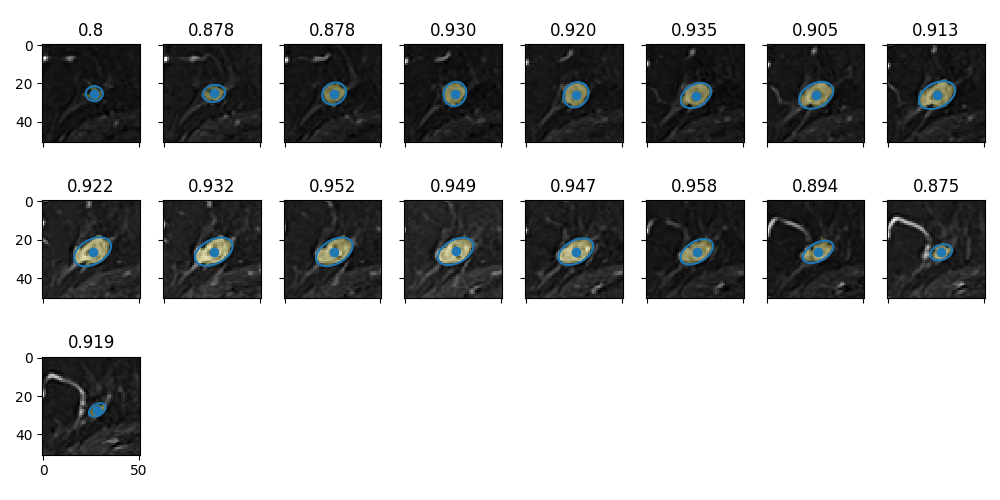

In [11]:
plot_slices(slices_im, slices_ma, slices_bb, slices_centers_dices, slices_contours_dices, slices_results_dices, len(max_dice_methods), 0, 255)

In [8]:
# open a file, where you stored the pickled data
file = open('baseline_results.pickle', 'rb')
# dump information to that file
data = pkl.load(file)

# open a file, where you stored the pickled data
file1 = open('baseline_results1.pickle', 'rb')
# dump information to that file
data1 = pkl.load(file1)

# open a file, where you stored the pickled data
file2 = open('baseline_results2.pickle', 'rb')
# dump information to that file
data2 = pkl.load(file2)

In [9]:
def rename_key_in_dict(data, old_key, new_key):
    for case, slices in data.items():
        for slice_id in slices.keys():
            if old_key in slices:
                slices[new_key] = slices.pop(old_key)
    return data

In [10]:
data = rename_key_in_dict(data, 'Dice_RPCE', 'Dice_RPCA')

In [11]:
# List of dictionaries to merge
dict_list = [data, data1, data2]

# Merging dictionaries
merged_dict = {}
for d in dict_list:
    for case, slices in d.items():
        if case not in merged_dict:
            merged_dict[case] = slices
        else:
            # Merge slices, keeping the most complete entry
            for slice_id, value in slices.items():
                if slice_id not in merged_dict[case] or merged_dict[case][slice_id] is None:
                    merged_dict[case][slice_id] = value

# Display the merged dictionary
import pprint
pprint.pprint(merged_dict)

{'/mnt/data/psteinmetz/neotex/to_process/Baseline_data/100_100': {'Dice_MCD': 0.44239631336405527,
                                                                  'Dice_PCA': 0.5238095238095238,
                                                                  'Dice_PCA_resized': 0.5231324757391108,
                                                                  'Dice_RPCA': 0.0,
                                                                  'Residuals_MCD': 1.6963691526169458,
                                                                  'Residuals_PCA': 2.3709624619239724,
                                                                  'Residuals_RPCA': 6.029294926073872},
 '/mnt/data/psteinmetz/neotex/to_process/Baseline_data/100_101': {'Dice_MCD': 0.5954198473282443,
                                                                  'Dice_PCA': 0.5555555555555556,
                                                                  'Dice_PCA_resized': 0.5605518650996424,
 

In [12]:
# Step 1: Initialize the restructured dictionary
restructured_data = {}

# Step 2: Iterate over the original dictionary
for key, values in merged_dict.items():
    # Extract patient number and slice
    _, patient_slice = key.rsplit('/', 1)
    patient, slice_ = patient_slice.split('_')
    
    # Compute the maximum Dice value
    max_dice = max(values['Dice_PCA'], values['Dice_MCD'], values['Dice_RPCA'])
    
    # Step 3: Populate the new dictionary
    if patient not in restructured_data:
        restructured_data[patient] = {}
    restructured_data[patient][slice_] = max_dice

In [13]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
data_train = dt.fread(path_to_csv).to_pandas()
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)
shape_modified = shape_target_train.replace('Oval', 'Round')
shape_modified.set_index('Record_ID', inplace=True)

In [14]:
restructured_data['63']

{'97': 0.7835051546391752,
 '98': 0.837037037037037,
 '99': 0.8820224719101124,
 '100': 0.8876190476190476,
 '101': 0.9161290322580645,
 '102': 0.9437229437229437,
 '103': 0.9405684754521964,
 '104': 0.9351535836177475,
 '105': 0.9259259259259259,
 '106': 0.9240174672489083,
 '107': 0.9362041467304625,
 '108': 0.9405646359583952,
 '109': 0.9494661921708185,
 '110': 0.9461914744933613,
 '111': 0.941425546930134,
 '112': 0.934876989869754,
 '113': 0.9240030097817908,
 '114': 0.9166666666666666,
 '115': 0.9096671949286846,
 '116': 0.910874897792314,
 '117': 0.9117903930131004,
 '118': 0.9099264705882353,
 '119': 0.9116465863453815,
 '120': 0.8876146788990825,
 '121': 0.8554744525547445,
 '122': 0.8152380952380952,
 '123': 0.7134146341463414}

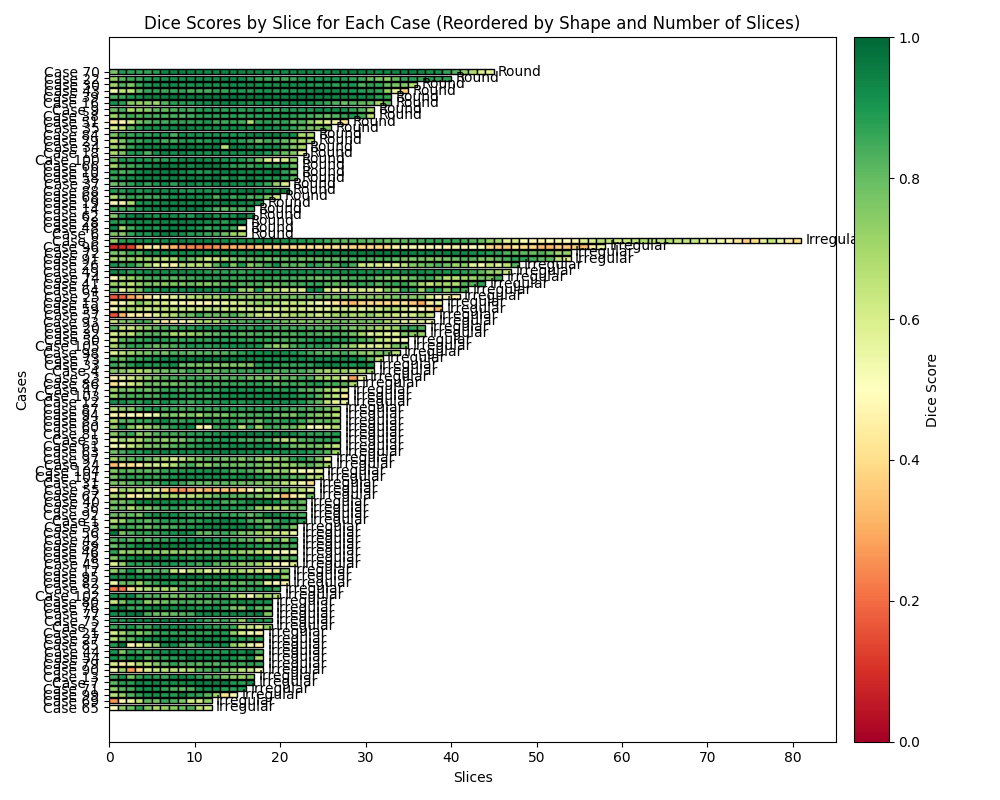

In [15]:
def plot_dice_scores_with_order(data, shape_df):
    """
    Creates a horizontal bar plot where each row represents a case, and each segment corresponds to a slice 
    colored by its Dice score. Reorders bars to have 'Round' shapes on top and 'Irregular' at the bottom,
    with cases sorted by the number of slices in ascending order within each shape.
    """
    # Sort data by shape and number of slices
    sorted_cases = sorted(
        data.items(),
        key=lambda x: (shape_df.loc[int(x[0]), 'Shape.1'], len(x[1]))
    )

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use the RdYlGn colormap
    cmap = plt.cm.RdYlGn
    norm = mcolors.Normalize(vmin=0, vmax=1)

    # Track the positions for the bar plot
    y_positions = range(len(sorted_cases))

    for i, (case_id, slices) in enumerate(sorted_cases):
        # Extract slice numbers and dice scores
        slice_ids = sorted(slices.keys(), key=int)
        dice_scores = [slices[slice_id] for slice_id in slice_ids]

        # Create the color map for the slices based on their Dice scores
        colors = [cmap(norm(score)) for score in dice_scores]

        # Plot each segment as a bar
        left = 0  # Starting position for the segment
        for j, (dice, color) in enumerate(zip(dice_scores, colors)):
            ax.barh(i, 1, left=left, height=0.8, color=color, edgecolor='black')
            left += 1

        # Add shape label at the end of the bar
        shape_label = shape_df.loc[int(case_id), 'Shape.1']
        ax.text(left + 0.5, i, shape_label, va='center', ha='left', fontsize=10, color='black')

    # Add labels and colorbar
    ax.set_xlabel('Slices')
    ax.set_ylabel('Cases')
    ax.set_title('Dice Scores by Slice for Each Case (Reordered by Shape and Number of Slices)')
    ax.set_yticks(y_positions)
    ax.set_yticklabels([f"Case {case_id}" for case_id, _ in sorted_cases])

    # Add a colorbar to show the Dice score scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Dice Score')

    plt.tight_layout()
    plt.show()


# Call the function with the reordered bars
plot_dice_scores_with_order(restructured_data, shape_modified)

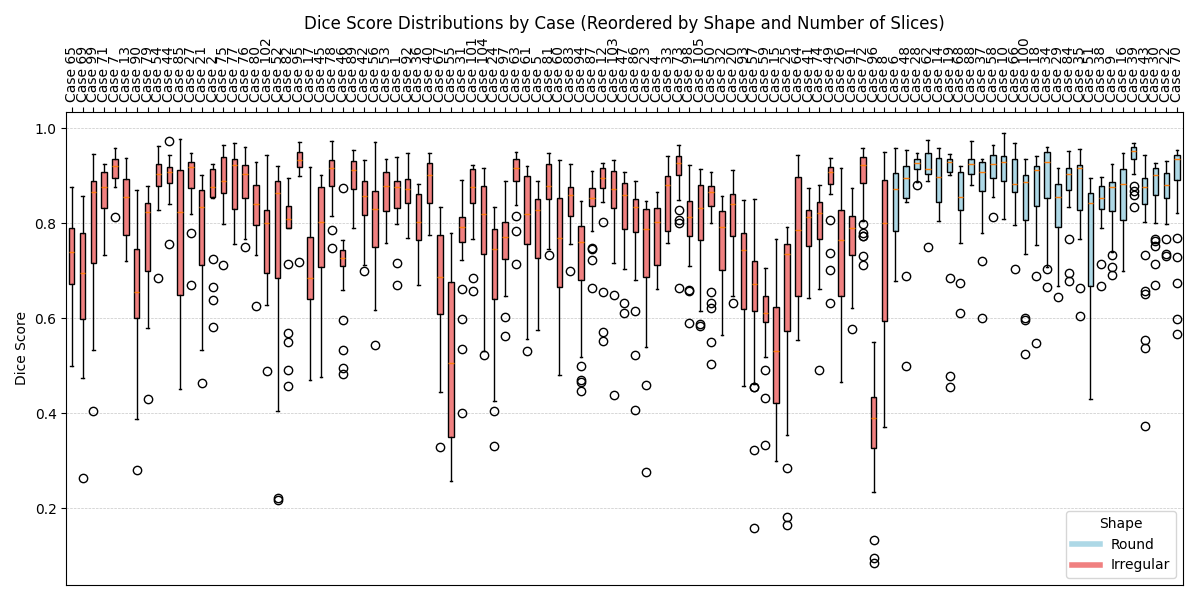

In [19]:
def plot_dice_distributions(data, shape_df):
    """
    Creates a vertical boxplot showing the Dice score distribution for each case, 
    reordered by shape ('Round' on top and 'Irregular' at the bottom) and 
    sorted by the number of slices within each shape.
    """
    # Sort data by shape and number of slices
    sorted_cases = sorted(
        data.items(),
        key=lambda x: (shape_df.loc[int(x[0]), 'Shape.1'], len(x[1]))
    )

    # Extract Dice scores and case IDs in sorted order
    case_ids = [case_id for case_id, _ in sorted_cases]
    dice_distributions = [list(slices.values()) for _, slices in sorted_cases]
    shapes = [shape_df.loc[int(case_id), 'Shape.1'] for case_id in case_ids]

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create the boxplot
    bplot = ax.boxplot(
        dice_distributions, 
        vert=True, 
        patch_artist=True
    )

    # Customize the boxplot
    colors = ['lightblue' if shape == 'Round' else 'lightcoral' for shape in shapes]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Add labels above the plot
    ax.xaxis.set_ticks_position('top')
    ax.set_xticks(range(1, len(case_ids) + 1))
    ax.set_xticklabels([f"Case {case_id}" for case_id in case_ids], rotation=90, fontsize=10, va='bottom')

    # Add labels, title, and legend
    ax.set_ylabel('Dice Score')
    ax.set_title('Dice Score Distributions by Case (Reordered by Shape and Number of Slices)')
    
    # Add a grid
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)  # Ensure grid is behind the boxes

    # Add legend for shape
    shape_colors = {'Round': 'lightblue', 'Irregular': 'lightcoral'}
    legend_patches = [plt.Line2D([0], [0], color=color, lw=4, label=shape) for shape, color in shape_colors.items()]
    ax.legend(handles=legend_patches, title='Shape', loc='lower right')

    plt.tight_layout()
    plt.show()


# Call the function with the reordered data
plot_dice_distributions(restructured_data, shape_modified)


In [ ]:
restructured_data

In [ ]:
import os
print(f"Number of CPU cores: {os.cpu_count()}")

In [ ]:
a_im.shape

In [ ]:
plot_1slice(final_image, final_mask, final_mask_bb, center, k, cont_ellipse, di, di_resized)

In [ ]:
plot_1slice(final_image, final_mask, final_mask_bb, center_MCD, k, cont_ellipse_MCD, di_MCD, di_resized)

In [ ]:
plot_1slice(final_image, final_mask, final_mask_bb, center_rpca, k, cont_ellipse_rpca, di_rpca, di_resized)

In [ ]:
a_ma_bb[91,207:215,85:95]

In [ ]:
np.where(a_ma_bb==1)

In [ ]:
final_mask_bb[100]

In [ ]:
plt.close('all')
plt.imshow(final_image[100], cmap='Greys_r')
plt.imshow(final_mask[100], alpha=0.25*(final_mask[100]>0))
plt.imshow(final_mask_bb[100], alpha=0.25*(final_mask_bb[100]>0))